# Third Order Approximation for N $\to\infty$

## Set Up

### Importing Packages

In [1]:
import numpy as np

import sympy as sym
from sympy.physics.paulialgebra import Pauli, evaluate_pauli_product
from sympy import I

import scipy as sc
import scipy.constants as scc
from scipy.integrate import solve_ivp

import matplotlib
import matplotlib.pyplot as plt

import csv
import json

from datetime import datetime
import os

from copy import *
import pickle

from qutip import *

from collections.abc import Iterable

from numba import jit

### Plotting Function

In [2]:
def plot_data(x_list, y_list, xlabel, ylabel, title, data, savedir = None):
    
    plt.figure(figsize=(4, 4), dpi=200)
    cmap = ['r', 'g', 'b', 'c', 'k', 'orange']
    
    label_size = 20

    plt.rc('text', usetex = True)
    plt.rc('xtick', labelsize=label_size) 
    plt.rc('ytick', labelsize=label_size)

    #c = cmap[i%len(cmap)]

    plt.plot(x_list, y_list, linestyle = '-', alpha=0.8)

    plt.xlabel(xlabel, fontsize = label_size)
    plt.ylabel(ylabel, fontsize = label_size)
    #plt.legend(fontsize = 0.8 * label_size)
        
        
    def savefig_(data, folder_initial_name):
        parent_dir = 'data/'
        path = os.path.join(parent_dir, ''.join([folder_initial_name,'_',datetime.now().strftime("%Y%m%d_%H%M%S")]))
        os.mkdir(path)

#         with open(os.path.join(path,'data.pkl'), 'wb') as file:
#             pickle.dump(data, file, pickle.HIGHEST_PROTOCOL)

        np.savetxt(os.path.join(path,'data.txt'), data)
        plt.savefig(os.path.join(path,'plot.png'), bbox_inches='tight')


    if savedir is not None:
        savefig_(data, savedir)
        
    plt.show()

### Defining the Symbols

In [3]:
S = dict()

w0, k, s = sym.symbols('omega_0 kappa S', real=True)
S['x'], S['y'], S['z'], S['p'], S['m'] = sym.symbols('S_x S_y S_z S_p S_m', commutative=False)

S['p'] = S['x'] + sym.I*S['y']
S['m'] = S['x'] - sym.I*S['y']

In [4]:
coords = ['x', 'y', 'z']

m = dict()
n = dict()
l = dict()
q = dict()

ch = dict()
tau = dict()

for i1 in coords:
    m[i1] = sym.symbols('m_%s' % i1, real=True)
for i1 in coords:
    for i2 in coords:
        n[i1+i2] = sym.symbols('n_%s%s' % (i1,i2), real=True)
        ch[i1+i2] = sym.symbols('chi_%s%s' % (i1,i2), real=True)
for i1 in coords:
    for i2 in coords:
        for i3 in coords:
            l[i1+i2+i3] = sym.symbols('l_%s%s%s' % (i1,i2,i3), real=True)
            tau[i1+i2+i3] = sym.symbols('tau_%s%s%s' % (i1,i2,i3), real=True)
for i1 in coords:
    for i2 in coords:
        for i3 in coords:
            for i4 in coords:
                q[i1+i2+i3+i4] = sym.symbols('q_%s%s%s%s' % (i1,i2,i3,i4), real=True)

### Defining the Commutators

In [5]:
def comm(A,B):
    if not isinstance(A, Iterable) and not isinstance(B, Iterable):
        if A == B:
            return 0
        elif A == S['x'] and B == S['y']:
            return I*S['z']
        elif A == S['x'] and B == S['z']:
            return -I*S['y']
        elif A == S['y'] and B == S['x']:
            return -I*S['z']
        elif A == S['y'] and B == S['z']:
            return I*S['x']
        elif A == S['z'] and B == S['x']:
            return I*S['y']
        elif A == S['z'] and B == S['y']:
            return -I*S['x']
        elif A == S['p'] and B == S['m']:
            return 2*S['z']
        elif A == S['m'] and B == S['p']:
            return -2*S['z']
        elif A == S['p']:
            return comm(S['x'],B)+I*comm(S['y'],B)
        elif A == S['m']:
            return comm(S['x'],B)-I*comm(S['y'],B)
        elif B == S['p']:
            return comm(A,S['x'])+I*comm(A,S['y'])
        elif B == S['m']:
            return comm(A,S['x'])-I*comm(A,S['y'])
        else:
            print('Error')
            return A*B - B*A
        
    elif isinstance(B, Iterable) and not isinstance(A, Iterable):
        if A == S['p']:
            res = 0
            for i in range(len(B)):
                temp_x = 1
                temp_y = 1
                for j in range(len(B)):
                    if i == j:
                        temp_x = temp_x*comm(S['x'],B[j])
                        temp_y = temp_y*comm(S['y'],B[j])
                    else:
                        temp_x = temp_x*B[j]
                        temp_y = temp_y*B[j]
                res = res + temp_x + sym.I*temp_y
                    
                
        elif A == S['m']:
            res = 0
            for i in range(len(B)):
                temp_x = 1
                temp_y = 1
                for j in range(len(B)):
                    if i == j:
                        temp_x = temp_x*comm(S['x'],B[j])
                        temp_y = temp_y*comm(S['y'],B[j])
                    else:
                        temp_x = temp_x*B[j]
                        temp_y = temp_y*B[j]
                res = res + temp_x - sym.I*temp_y
        
        else:
            res = 0
            for i in range(len(B)):
                temp = 1
                for j in range(len(B)):
                    if i == j:
                        temp = temp*comm(A,B[j])
                    else:
                        temp = temp*B[j]
                res = res + temp
        
        return res
    
    elif isinstance(A, Iterable) and not isinstance(B, Iterable):
        return -comm(B,A)
    
    else:
        print('Error')
        return 0

### Simplification Substitutions

In [6]:
subs_list = dict()

for i1 in coords:
    subs_list[S[i1]/s] = m[i1]
for i1 in coords:
    for i2 in coords:
        subs_list[(S[i1]*S[i2])/(s**2)] = n[i1+i2]
for i1 in coords:
    for i2 in coords:
        for i3 in coords:
            subs_list[(S[i1]*S[i2]*S[i3])/(s**3)] = l[i1+i2+i3]
for i1 in coords:
    for i2 in coords:
        for i3 in coords:
            for i4 in coords:
                subs_list[(S[i1]*S[i2]*S[i3]*S[i4])/(s**4)] = q[i1+i2+i3+i4]

In [7]:
q_subs_list = dict()
for i1 in coords:
    for i2 in coords:
        for i3 in coords:
            for i4 in coords:
                q_subs_list[q[i1+i2+i3+i4]] = m[i1]*l[i2+i3+i4] + m[i2]*l[i1+i3+i4] + m[i3]*l[i1+i2+i4] + m[i4]*l[i1+i2+i3] +\
                                                n[i1+i2]*n[i3+i4] + n[i1+i3]*n[i2+i4] + n[i1+i4]*n[i2+i3] -\
                                                 2*(n[i1+i2]*m[i3]*m[i4] + n[i1+i3]*m[i2]*m[i4] + n[i1+i4]*m[i2]*m[i3] + n[i2+i3]*m[i1]*m[i4] + n[i2+i4]*m[i1]*m[i3] + n[i3+i4]*m[i1]*m[i2]) +\
                                                  6*m[i1]*m[i2]*m[i3]*m[i4]

In [8]:
comm_subs_list = dict()

for i1 in coords:
    for i2 in coords:
        temp = np.sort([i1,i2])
        comm_subs_list[n[i1+i2]] = n[temp[0]+temp[1]]
for i1 in coords:
    for i2 in coords:
        for i3 in coords:
            temp = np.sort([i1,i2,i3])
            comm_subs_list[l[i1+i2+i3]] = l[temp[0]+temp[1]+temp[2]]

In [9]:
var_comm_subs_list = dict()

for i1 in coords:
    for i2 in coords:
        temp = np.sort([i1,i2])
        comm_subs_list[ch[i1+i2]] = ch[temp[0]+temp[1]]
for i1 in coords:
    for i2 in coords:
        for i3 in coords:
            temp = np.sort([i1,i2,i3])
            comm_subs_list[tau[i1+i2+i3]] = tau[temp[0]+temp[1]+temp[2]]

In [10]:
cumulant_subs_list = dict()

for i1 in coords:
    for i2 in coords:
        cumulant_subs_list[n[i1+i2]] = ch[i1+i2] + m[i1]*m[i2]
for i1 in coords:
    for i2 in coords:
        for i3 in coords:
            cumulant_subs_list[l[i1+i2+i3]] = tau[i1+i2+i3] + m[i1]*ch[i2+i3] + m[i2]*ch[i1+i3] + m[i3]*ch[i1+i2] + m[i1]*m[i2]*m[i3]

## Framing the Equations

In [14]:
def diff(O):
    H = S['x']
    return sym.I*w0*comm(H,O) + (k/(s))*(comm(S['p'],O)*S['m'] + S['p']*comm(O,S['m']))

In [15]:
op_list = list()
key_list = list()
var_key_list = list()

for i1 in coords:
    op_list.append(S[i1])
    key_list.append(m[i1])
    var_key_list.append(m[i1])
for i1 in coords:
    for i2 in coords:
        op_list.append((S[i1],S[i2]))
        key_list.append(n[i1+i2])
        var_key_list.append(ch[i1+i2])
for i1 in coords:
    for i2 in coords:
        for i3 in coords:
            op_list.append((S[i1],S[i2],S[i3]))
            key_list.append(l[i1+i2+i3])
            var_key_list.append(tau[i1+i2+i3])

In [16]:
diff_list = dict()
var_diff_list = dict()
for i,O in enumerate(op_list):
    N = len(O) if isinstance(O, Iterable) else 1
    exp = sym.expand(diff(O)/(s**N))
    exp1 = exp.subs(subs_list)
    exp2 = sym.simplify(exp1.subs(q_subs_list))
    exp3 = sym.simplify(exp2.subs(comm_subs_list))
    diff_list[key_list[i]] = exp3
    var_diff_list[key_list[i]] = exp3

In [17]:
def mean_to_dev():
    for key, values in var_diff_list.items():
        var_diff_list[key] = sym.simplify(sym.expand(var_diff_list[key].subs(cumulant_subs_list)))
        
    for i1 in coords:
        for i2 in coords:
            var_diff_list[ch[i1+i2]] = var_diff_list[n[i1+i2]] - m[i1]*var_diff_list[m[i2]] - m[i2]*var_diff_list[m[i1]]
    
    for i1 in coords:
        for i2 in coords:
            for i3 in coords:
                var_diff_list[tau[i1+i2+i3]] = var_diff_list[l[i1+i2+i3]] -\
                 (m[i1]*var_diff_list[ch[i2+i3]] + m[i2]*var_diff_list[ch[i1+i3]] + m[i3]*var_diff_list[ch[i1+i2]])-\
                  (var_diff_list[m[i1]]*ch[i2+i3] + var_diff_list[m[i2]]*ch[i1+i3] + var_diff_list[m[i3]]*ch[i1+i2])-\
                   (var_diff_list[m[i1]]*m[i2]*m[i3] + var_diff_list[m[i2]]*m[i1]*m[i3] + var_diff_list[m[i3]]*m[i1]*m[i2])
                
    for i1 in coords:
        for i2 in coords:
            var_diff_list.pop(n[i1+i2])
    
    for i1 in coords:
        for i2 in coords:
            for i3 in coords:
                var_diff_list.pop(l[i1+i2+i3])


    for key, values in var_diff_list.items():
        exp = sym.simplify(var_diff_list[key].subs(var_comm_subs_list))
        var_diff_list[key] = sym.expand(sym.simplify(exp))

In [18]:
mean_to_dev()

In [19]:
for key in diff_list:
#     print(sym.latex(key))
    print(sym.latex(diff_list[key]))
    #display(key,diff_list[key])
    print()

2 \kappa n_{xz}

2 \kappa n_{yz} - m_{z} \omega_{0}

- 2 \kappa n_{xx} - 2 \kappa n_{yy} + m_{y} \omega_{0}

4 \kappa l_{xxz}

4 \kappa l_{xyz} - n_{xz} \omega_{0}

- 2 \kappa l_{xxx} - 2 \kappa l_{xyy} + 2 \kappa l_{xzz} + n_{xy} \omega_{0}

4 \kappa l_{xyz} - n_{xz} \omega_{0}

4 \kappa l_{yyz} - 2 n_{yz} \omega_{0}

- 2 \kappa l_{xxy} - 2 \kappa l_{yyy} + 2 \kappa l_{yzz} + n_{yy} \omega_{0} - n_{zz} \omega_{0}

- 2 \kappa l_{xxx} - 2 \kappa l_{xyy} + 2 \kappa l_{xzz} + n_{xy} \omega_{0}

- 2 \kappa l_{xxy} - 2 \kappa l_{yyy} + 2 \kappa l_{yzz} + n_{yy} \omega_{0} - n_{zz} \omega_{0}

- 4 \kappa l_{xxz} - 4 \kappa l_{yyz} + 2 n_{yz} \omega_{0}

6 \kappa \left(l_{xxx} m_{z} + 3 l_{xxz} m_{x} + 6 m_{x}^{3} m_{z} - 6 m_{x}^{2} n_{xz} - 6 m_{x} m_{z} n_{xx} + 3 n_{xx} n_{xz}\right)

6 \kappa l_{xxy} m_{z} + 6 \kappa l_{xxz} m_{y} + 12 \kappa l_{xyz} m_{x} + 36 \kappa m_{x}^{2} m_{y} m_{z} - 12 \kappa m_{x}^{2} n_{yz} - 24 \kappa m_{x} m_{y} n_{xz} - 24 \kappa m_{x} m_{z} n_{xy} - 12 \ka

- 4 \kappa l_{xxy} m_{z} - 4 \kappa l_{xxz} m_{y} - 8 \kappa l_{xyz} m_{x} - 4 \kappa l_{yyy} m_{z} - 12 \kappa l_{yyz} m_{y} + 6 \kappa l_{yzz} m_{z} + 2 \kappa l_{zzz} m_{y} - 24 \kappa m_{x}^{2} m_{y} m_{z} + 8 \kappa m_{x}^{2} n_{yz} + 16 \kappa m_{x} m_{y} n_{xz} + 16 \kappa m_{x} m_{z} n_{xy} - 24 \kappa m_{y}^{3} m_{z} + 24 \kappa m_{y}^{2} n_{yz} + 12 \kappa m_{y} m_{z}^{3} + 8 \kappa m_{y} m_{z} n_{xx} + 24 \kappa m_{y} m_{z} n_{yy} - 12 \kappa m_{y} m_{z} n_{zz} - 12 \kappa m_{z}^{2} n_{yz} - 4 \kappa n_{xx} n_{yz} - 8 \kappa n_{xy} n_{xz} - 12 \kappa n_{yy} n_{yz} + 6 \kappa n_{yz} n_{zz} + 2 l_{yyz} \omega_{0} - l_{zzz} \omega_{0}

- 4 \kappa l_{xxx} m_{z} - 12 \kappa l_{xxz} m_{x} - 4 \kappa l_{xyy} m_{z} - 8 \kappa l_{xyz} m_{y} + 6 \kappa l_{xzz} m_{z} - 4 \kappa l_{yyz} m_{x} + 2 \kappa l_{zzz} m_{x} - 24 \kappa m_{x}^{3} m_{z} + 24 \kappa m_{x}^{2} n_{xz} - 24 \kappa m_{x} m_{y}^{2} m_{z} + 16 \kappa m_{x} m_{y} n_{yz} + 12 \kappa m_{x} m_{z}^{3} + 24 \kappa m_{x} m_{z

In [20]:
for key in var_diff_list:
    print(sym.latex(key))
    print(sym.latex(var_diff_list[key]))
    #display(key,var_diff_list[key])
    print()

m_{x}
2 \chi_{xz} \kappa + 2 \kappa m_{x} m_{z}

m_{y}
2 \chi_{yz} \kappa + 2 \kappa m_{y} m_{z} - m_{z} \omega_{0}

m_{z}
- 2 \chi_{xx} \kappa - 2 \chi_{yy} \kappa - 2 \kappa m_{x}^{2} - 2 \kappa m_{y}^{2} + m_{y} \omega_{0}

\chi_{xx}
4 \chi_{xx} \kappa m_{z} + 4 \chi_{xz} \kappa m_{x} + 4 \kappa \tau_{xxz}

\chi_{xy}
4 \chi_{xy} \kappa m_{z} + 2 \chi_{xz} \kappa m_{y} - \chi_{xz} \omega_{0} + 2 \chi_{yz} \kappa m_{x} + 4 \kappa \tau_{xyz}

\chi_{xz}
- 4 \chi_{xx} \kappa m_{x} - 4 \chi_{xy} \kappa m_{y} + \chi_{xy} \omega_{0} + 2 \chi_{xz} \kappa m_{z} + 2 \chi_{zz} \kappa m_{x} - 2 \kappa \tau_{xxx} - 2 \kappa \tau_{xyy} + 2 \kappa \tau_{xzz}

\chi_{yx}
4 \chi_{xy} \kappa m_{z} + 2 \chi_{xz} \kappa m_{y} - \chi_{xz} \omega_{0} + 2 \chi_{yz} \kappa m_{x} + 4 \kappa \tau_{xyz}

\chi_{yy}
4 \chi_{yy} \kappa m_{z} + 4 \chi_{yz} \kappa m_{y} - 2 \chi_{yz} \omega_{0} + 4 \kappa \tau_{yyz}

\chi_{yz}
- 4 \chi_{xy} \kappa m_{x} - 4 \chi_{yy} \kappa m_{y} + \chi_{yy} \omega_{0} + 2 \chi_{yz}

## Solving the Equations

In [19]:
def eval_expr(diff_list):
    delta = diff_list
    f_list = list()
    for key in delta.keys():
        f = sym.lambdify([(w0,k,*var_key_list)], delta[key])
        #f_list.append(f(args))
        f_list.append(f)
    return f_list

In [20]:
f_list = eval_expr(var_diff_list)

In [21]:
def solve(t, initial_conditions, k, w0):
    #m_y, m_z, n_yy, n_yz, n_zz  = initial_conditions
    val_list = list()
    print(f'time: {np.round(t,5)}s', end = '\r')
    args = (w0,k,*initial_conditions)
    for f in f_list:
        val_list.append(f(args))
    return val_list

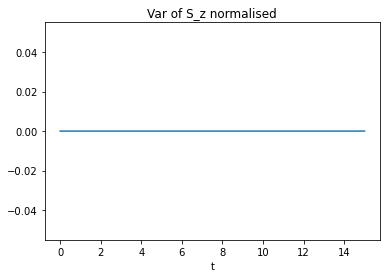

In [22]:
init_cond = [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
sol = solve_ivp(solve, [0, 15], init_cond, args=(0.2, 1), dense_output=True, method='BDF', max_step=0.001)
t = np.linspace(0, 15, 2000)
z = sol.sol(t)
y = z.T[:,11]
#y = z.T[:,2]
plt.plot(t, y)
plt.xlabel('t')
#plt.legend(['x', 'y'], shadow=True)
plt.title('Var of S_z normalised')
plt.show()

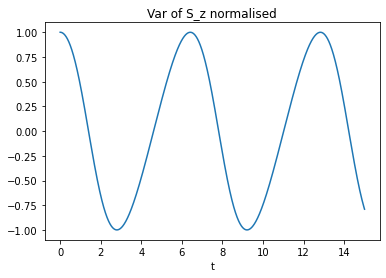

In [23]:
y = z.T[:,2]
#y = z.T[:,2]
plt.plot(t, y)
plt.xlabel('t')
#plt.legend(['x', 'y'], shadow=True)
plt.title('Var of S_z normalised')
plt.show()

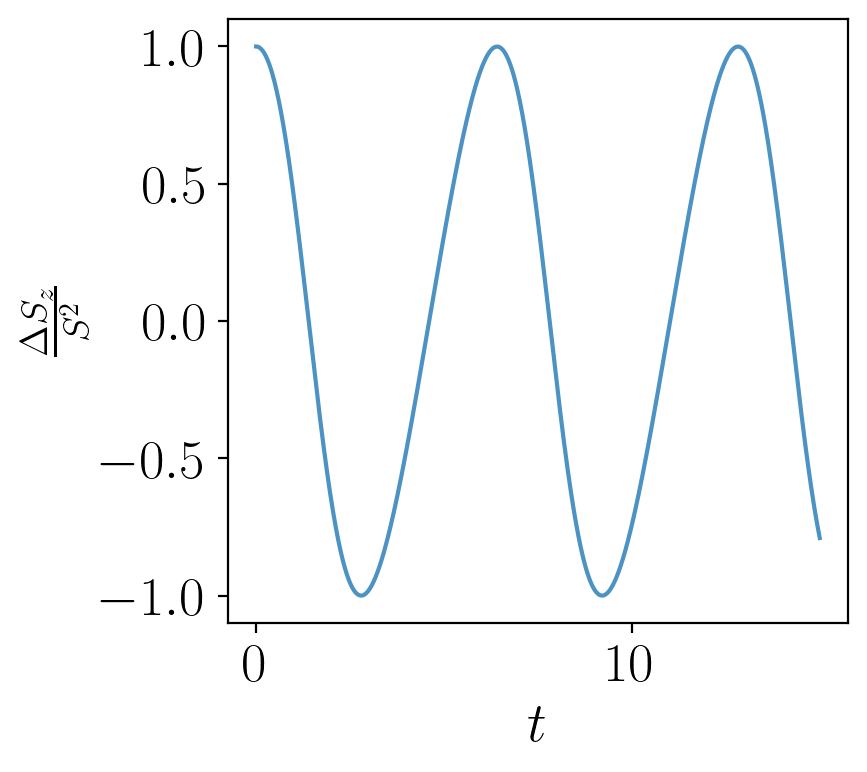

In [24]:
data = np.concatenate([t.reshape(1,len(t)),z])
plot_data(t, y, r'$t$', r'$\frac{\Delta S_z}{S^2}$', r'Variance of $S_z$ Normalised', data, savedir = 'Third_order_inf_N')